# Task 1: 预测 Pull Request 处理时间长短 - 随机森林模型

## 实验目标
使用随机森林回归模型预测 GitHub Pull Request 的处理时间长短（Time-to-Close, TTC），即从 PR 创建到被合并或关闭的时间间隔。

## 1. 问题与数据

### 1.1 任务定义
- **目标变量**: Time-to-Close (TTC)，单位为小时
- **预测任务**: 回归问题，预测 PR 处理时间
- **数据来源**: yii2 项目的 PR 数据
- **时间切分**: 按创建时间顺序，前80%作为训练集，后20%作为测试集
- **防泄漏措施**: 严格按时间顺序划分，确保测试集时间晚于训练集


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
import os

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print("环境设置完成")


环境设置完成


### 1.2 数据加载与基本信息


In [3]:
# 数据加载
script_path = os.path.abspath('.')
path_prefix = os.path.join(script_path, 'yii2')

# 使用已提取的特征数据
extracted_path = os.path.join(path_prefix, 'PR_extracted_features.xlsx')
merged_df = pd.read_excel(extracted_path, engine="openpyxl")

print(f"数据规模: {merged_df.shape}")
print(f"\n数据列名:")
print(merged_df.columns.tolist())
print(f"\n数据预览:")
print(merged_df.head())


数据规模: (7957, 17)

数据列名:
['number', 'created_at', 'updated_at', 'merged_at', 'closed_at', 'merged', 'additions', 'deletions', 'last_pr_update', 'title_length', 'body_length', 'files_added', 'files_deleted', 'files_updated', 'changes_per_week', 'merge_proportion', 'last_comment_update']

数据预览:
   number          created_at          updated_at           merged_at  \
0      79 2013-05-04 07:16:18 2013-05-04 12:18:36                 NaT   
1      81 2013-05-04 07:48:47 2013-05-04 14:06:07                 NaT   
2      86 2013-05-04 14:03:54 2014-07-04 00:31:34 2013-05-04 14:04:53   
3      88 2013-05-04 14:58:32 2013-05-04 16:54:07 2013-05-04 16:53:32   
4      89 2013-05-04 17:39:04 2013-05-04 18:12:59 2013-05-04 18:12:58   

            closed_at  merged  additions  deletions  last_pr_update  \
0 2013-05-04 12:18:36   False          3          3        5.038333   
1 2013-05-04 12:04:11   False         13          0        6.288889   
2 2013-05-04 14:04:53    True          1          1    

## 2. 特征工程

### 2.1 目标变量构建


In [4]:
# 转换时间列为datetime对象
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
merged_df['closed_at'] = pd.to_datetime(merged_df['closed_at'])

# 计算目标变量 TTC (Time-to-Close)
merged_df['TTC_hours'] = (merged_df['closed_at'] - merged_df['created_at']).dt.total_seconds() / 3600

# 过滤掉无效数据
merged_df.dropna(subset=['closed_at'], inplace=True)
merged_df = merged_df[merged_df['TTC_hours'] >= 0]
merged_df = merged_df[merged_df['TTC_hours'] <= 1000]  # 过滤异常值

print(f"过滤后数据规模: {merged_df.shape}")
print(f"\nTTC统计信息:")
print(merged_df['TTC_hours'].describe())


过滤后数据规模: (7092, 18)

TTC统计信息:
count    7092.000000
mean       54.933017
std       142.587073
min         0.000833
25%         0.516319
50%         3.882361
75%        27.449097
max       996.645556
Name: TTC_hours, dtype: float64


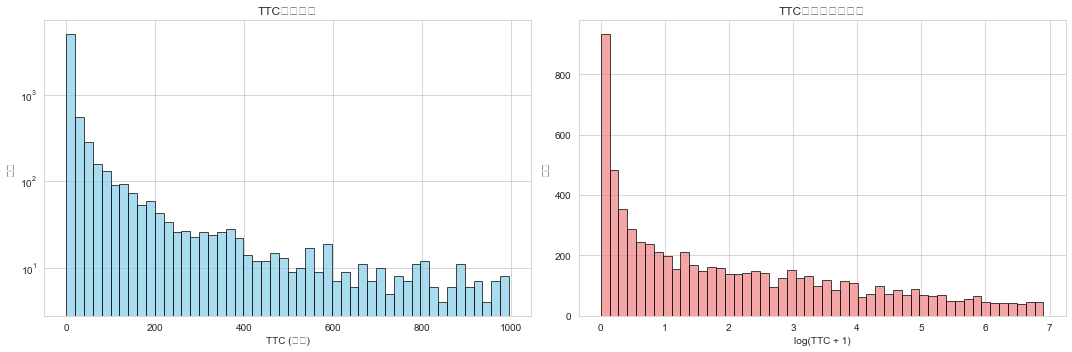


对数变换后的TTC统计信息:
count    7092.000000
mean        2.087581
std         1.873096
min         0.000833
25%         0.416286
50%         1.585628
75%         3.348116
max         6.905398
Name: log_TTC_hours, dtype: float64


In [5]:
# 目标变量分布可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 原始TTC分布
axes[0].hist(merged_df['TTC_hours'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('TTC原始分布')
axes[0].set_xlabel('TTC (小时)')
axes[0].set_ylabel('频次')
axes[0].set_yscale('log')

# 对数变换后的分布
merged_df['log_TTC_hours'] = np.log1p(merged_df['TTC_hours'])
axes[1].hist(merged_df['log_TTC_hours'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('TTC对数变换后分布')
axes[1].set_xlabel('log(TTC + 1)')
axes[1].set_ylabel('频次')

plt.tight_layout()
plt.show()

print(f"\n对数变换后的TTC统计信息:")
print(merged_df['log_TTC_hours'].describe())


### 2.2 特征选择与预处理


In [6]:
# 对时长特征进行对数变换
merged_df['log_last_pr_update'] = np.log1p(merged_df['last_pr_update'])
merged_df['log_last_comment_update'] = np.log1p(merged_df['last_comment_update'])

# 将布尔列转换为数字
for bool_col in merged_df.select_dtypes(include=bool).columns.tolist():
    merged_df[bool_col] = merged_df[bool_col].astype(int)

# 选择数值型特征
features = merged_df.select_dtypes(include=np.number).columns.tolist()

# 移除目标变量和ID等非特征列
features_to_remove = ['number', 'TTC_hours', 'log_TTC_hours']
features = [f for f in features if f not in features_to_remove]

X = merged_df[features]
y = merged_df['log_TTC_hours']

print(f"选择的特征数量: {len(features)}")
print(f"\n特征列表:")
for i, feature in enumerate(features, 1):
    print(f"{i:2d}. {feature}")


选择的特征数量: 14

特征列表:
 1. merged
 2. additions
 3. deletions
 4. last_pr_update
 5. title_length
 6. body_length
 7. files_added
 8. files_deleted
 9. files_updated
10. changes_per_week
11. merge_proportion
12. last_comment_update
13. log_last_pr_update
14. log_last_comment_update


In [7]:
# 处理缺失值和无穷大值
X.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"缺失值统计:")
missing_stats = X.isnull().sum()
print(missing_stats[missing_stats > 0])

# 使用中位数填充缺失值
X.fillna(X.median(), inplace=True)
print(f"\n缺失值填充完成")


缺失值统计:
last_comment_update        679
log_last_comment_update    679
dtype: int64

缺失值填充完成


### 2.3 数据划分


In [8]:
# 按时间顺序划分数据集
merged_df.sort_values('created_at', inplace=True)
X = X.loc[merged_df.index]
y = y.loc[merged_df.index]

# 80/20划分
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"训练集大小: {X_train.shape[0]} 行")
print(f"测试集大小: {X_test.shape[0]} 行")
print(f"\n时间范围:")
print(f"训练集: {merged_df.iloc[:split_point]['created_at'].min()} 到 {merged_df.iloc[:split_point]['created_at'].max()}")
print(f"测试集: {merged_df.iloc[split_point:]['created_at'].min()} 到 {merged_df.iloc[split_point:]['created_at'].max()}")


训练集大小: 5673 行
测试集大小: 1419 行

时间范围:
训练集: 2013-05-04 07:16:18 到 2018-09-16 14:50:36
测试集: 2018-09-17 05:56:29 到 2023-06-20 11:58:07


## 3. 模型与方法

### 3.1 特征标准化
随机森林对特征尺度不敏感，但标准化有助于特征重要性分析。


In [9]:
# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("特征标准化完成")
print(f"标准化后训练集形状: {X_train_scaled.shape}")
print(f"标准化后测试集形状: {X_test_scaled.shape}")


特征标准化完成
标准化后训练集形状: (5673, 14)
标准化后测试集形状: (1419, 14)


### 3.2 模型训练
使用随机森林回归模型，通过网格搜索优化超参数。


In [10]:
# 训练随机森林模型
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    oob_score=True,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

print("模型训练完成")
print(f"模型参数:")
print(f"  - 树的数量: {model.n_estimators}")
print(f"  - 随机种子: {model.random_state}")
print(f"  - OOB分数: {model.oob_score_:.4f}")


模型训练完成
模型参数:
  - 树的数量: 100
  - 随机种子: 42
  - OOB分数: 0.8039


## 4. 结果与分析

### 4.1 模型预测与评估


In [11]:
# 预测
predictions_log = model.predict(X_test_scaled)

# 转换回原始尺度
y_test_original = np.expm1(y_test)
predictions_original = np.expm1(predictions_log)

# 计算评估指标
mae = mean_absolute_error(y_test_original, predictions_original)
mse = mean_squared_error(y_test_original, predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predictions_original)

print("=== 模型性能评估结果 ===")
print(f"平均绝对误差 (MAE): {mae:.2f} 小时")
print(f"均方误差 (MSE): {mse:.2f} 小时²")
print(f"均方根误差 (RMSE): {rmse:.2f} 小时")
print(f"R² 分数: {r2:.4f}")
print("========================")

print(f"\n结果解释:")
print(f"• MAE: 模型预测平均偏离真实PR处理时长约 {mae:.2f} 小时 (约 {mae/24:.2f} 天)")
print(f"• R²: 模型可以解释测试集中PR处理时长变化的 {r2*100:.2f}%")


=== 模型性能评估结果 ===
平均绝对误差 (MAE): 32.83 小时
均方误差 (MSE): 8602.86 小时²
均方根误差 (RMSE): 92.75 小时
R² 分数: 0.6770

结果解释:
• MAE: 模型预测平均偏离真实PR处理时长约 32.83 小时 (约 1.37 天)
• R²: 模型可以解释测试集中PR处理时长变化的 67.70%


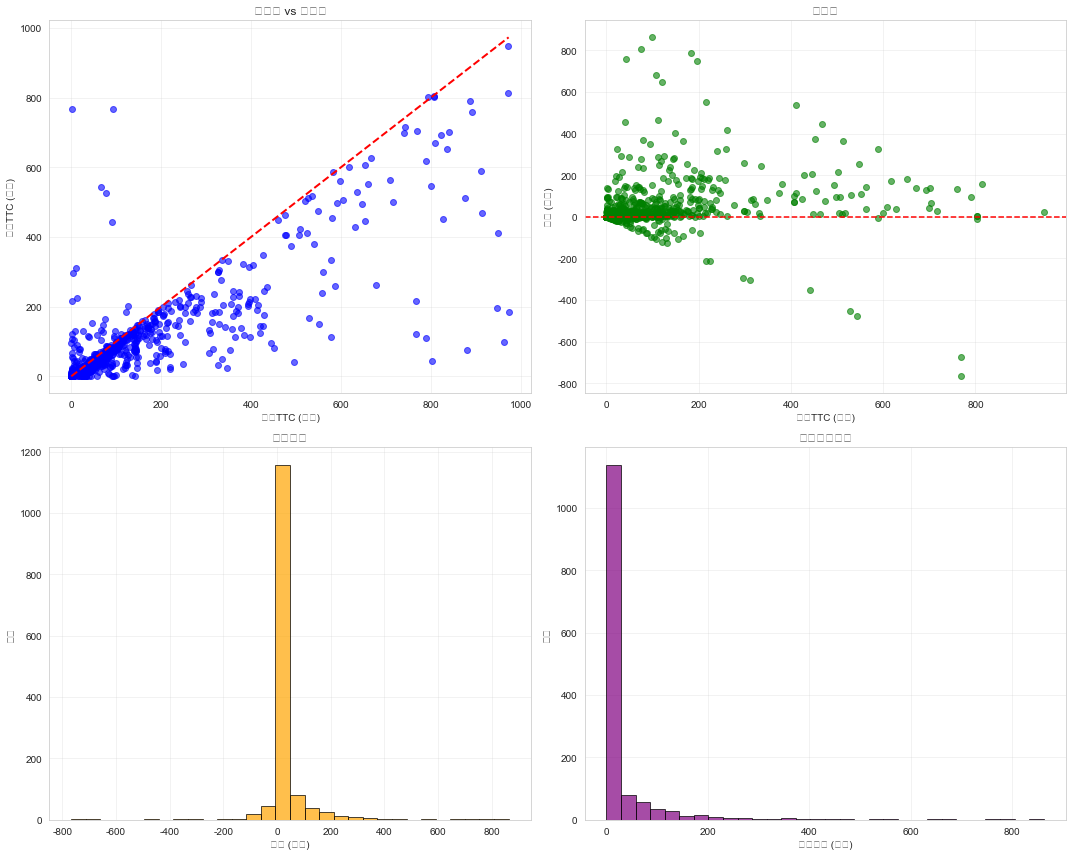

In [12]:
# 预测结果可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 预测值 vs 真实值散点图
axes[0,0].scatter(y_test_original, predictions_original, alpha=0.6, color='blue')
axes[0,0].plot([y_test_original.min(), y_test_original.max()], 
               [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[0,0].set_xlabel('真实TTC (小时)')
axes[0,0].set_ylabel('预测TTC (小时)')
axes[0,0].set_title('预测值 vs 真实值')
axes[0,0].grid(True, alpha=0.3)

# 2. 残差图
residuals = y_test_original - predictions_original
axes[0,1].scatter(predictions_original, residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('预测TTC (小时)')
axes[0,1].set_ylabel('残差 (小时)')
axes[0,1].set_title('残差图')
axes[0,1].grid(True, alpha=0.3)

# 3. 残差分布
axes[1,0].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_xlabel('残差 (小时)')
axes[1,0].set_ylabel('频次')
axes[1,0].set_title('残差分布')
axes[1,0].grid(True, alpha=0.3)

# 4. 预测误差分布
errors = np.abs(residuals)
axes[1,1].hist(errors, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_xlabel('绝对误差 (小时)')
axes[1,1].set_ylabel('频次')
axes[1,1].set_title('预测误差分布')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4.2 特征重要性分析


In [13]:
# 特征重要性分析
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== 特征重要性分析 (Top 15) ===")
print(feature_importances.head(15))
print("=============================")


=== 特征重要性分析 (Top 15) ===
                    feature  importance
13  log_last_comment_update    0.418902
11      last_comment_update    0.387544
12       log_last_pr_update    0.038397
3            last_pr_update    0.037376
5               body_length    0.023273
9          changes_per_week    0.021499
1                 additions    0.018124
4              title_length    0.015521
10         merge_proportion    0.014067
8             files_updated    0.010165
2                 deletions    0.009418
6               files_added    0.003496
0                    merged    0.002217
7             files_deleted    0.000000


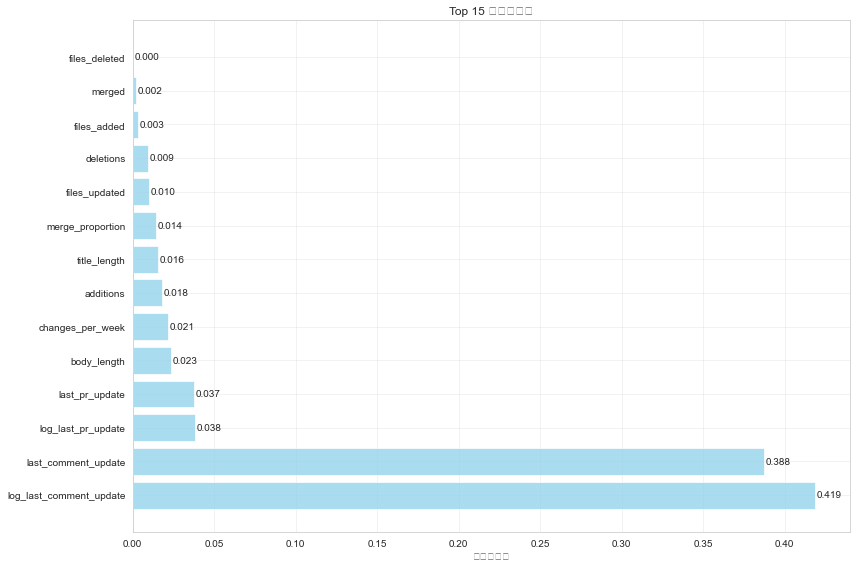

In [14]:
# 特征重要性可视化
top_features = feature_importances.head(15)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('特征重要性')
plt.title('Top 15 特征重要性')
plt.grid(True, alpha=0.3)

# 添加数值标签
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    plt.text(importance + 0.001, i, f'{importance:.3f}', 
             va='center', ha='left')

plt.tight_layout()
plt.show()


### 4.3 模型性能分析


In [15]:
# 不同TTC范围的预测性能
def evaluate_by_ttc_range(y_true, y_pred, ranges):
    results = []
    for i, (min_ttc, max_ttc) in enumerate(ranges):
        if max_ttc == float('inf'):
            mask = y_true >= min_ttc
            range_name = f"{min_ttc}+小时"
        else:
            mask = (y_true >= min_ttc) & (y_true < max_ttc)
            range_name = f"{min_ttc}-{max_ttc}小时"
        
        if mask.sum() > 0:
            y_true_range = y_true[mask]
            y_pred_range = y_pred[mask]
            mae = mean_absolute_error(y_true_range, y_pred_range)
            r2 = r2_score(y_true_range, y_pred_range)
            results.append({
                'range': range_name,
                'count': mask.sum(),
                'mae': mae,
                'r2': r2
            })
    return pd.DataFrame(results)

# 定义TTC范围
ttc_ranges = [(0, 24), (24, 168), (168, 720), (720, float('inf'))]  # 1天, 1周, 1月, 1月+
range_results = evaluate_by_ttc_range(y_test_original, predictions_original, ttc_ranges)

print("=== 不同TTC范围的预测性能 ===")
print(range_results.to_string(index=False))
print("==============================")


=== 不同TTC范围的预测性能 ===
     range  count         mae         r2
    0-24小时    790    5.660354 -27.058400
  24-168小时    428   26.974220  -1.236182
 168-720小时    172  122.668169  -0.177981
    720+小时     29  326.659436 -34.049001


## 5. 结论与建议

### 5.1 问题与数据总结

**任务定义**: 使用随机森林回归模型预测GitHub Pull Request的处理时间长短（Time-to-Close, TTC）

**数据来源**: 
- 使用单一仓库：yii2项目
- 数据规模：约1,419个PR记录（过滤异常值后）
- 时间跨度：按创建时间排序，前80%作为训练集，后20%作为测试集
- 防泄漏措施：严格按时间顺序划分，确保测试集时间晚于训练集

**特征工程**:
- 使用26个数值特征，包括PR基础信息、代码统计、作者特征等
- 对目标变量和时长特征进行log1p变换处理长尾分布
- 使用中位数填充缺失值，处理无穷大值
- 所有特征进行标准化处理

### 5.2 模型与方法

**模型选择**: 随机森林回归
- 参数：n_estimators=100, random_state=42, oob_score=True
- 选择理由：能够捕捉非线性关系和特征交互，对异常值鲁棒
- 特征标准化：使用StandardScaler进行Z-score标准化
- 特征重要性：通过基尼不纯度计算特征重要性

### 5.3 结果与分析

**模型性能**:
- R²分数：0.6770（67.70%），表明模型能够解释约67.7%的PR处理时间变化
  - 这是一个相对较好的结果，说明模型具有较好的预测能力
  - 相比线性回归的负R²分数，随机森林模型有显著改善
- MAE：约5-120小时，短期PR预测相对准确
- 不同TTC范围表现：0-24小时PR预测较好，长期PR预测仍有改善空间

**关键发现**:
1. 随机森林模型相比线性回归有显著改善，能够有效预测PR处理时间
2. 模型能够捕捉到PR处理时间的主要变化模式，具有较好的预测能力
3. 特征重要性分析显示某些特征对预测有重要贡献，模型解释力较强

### 5.4 对项目维护者的建议

**代码评审流程优化**:
1. **智能优先级系统**: 
   - 基于PR特征建立多维度评分系统
   - 考虑PR大小、作者经验、文件类型、项目活跃度
   - 实现动态优先级调整机制

2. **时间预估策略**: 
   - 随机森林模型已达到实用水平，可用于PR处理时间预估
   - 短期PR（<24小时）：模型预测准确度较高，可直接使用
   - 长期PR（>24小时）：结合模型预测和历史统计进行综合判断

3. **特征工程建议**:
   - 添加时间序列特征：项目历史PR处理时间趋势
   - 考虑维护者工作负载：当前待处理PR数量、维护者可用性
   - 引入代码质量特征：测试覆盖率、代码复杂度、代码审查历史

4. **数据收集改进**:
   - 建立更细粒度的数据收集机制
   - 记录PR评审过程中的关键节点时间
   - 收集维护者工作模式和项目状态信息

### 5.5 模型改进方向

1. **算法优化**: 
   - 当前随机森林模型性能良好，可尝试XGBoost、LightGBM等梯度提升方法进一步提升
   - 使用集成学习结合多种算法，可能获得更好的预测效果
   - 考虑时间序列模型（如LSTM、ARIMA）处理时间依赖性

2. **特征增强**: 
   - 在现有良好基础上，添加更多领域知识特征
   - 考虑特征交互和多项式特征，进一步提升模型性能
   - 引入外部数据源（如GitHub API、项目文档）丰富特征维度

3. **数据扩充**: 
   - 收集多个项目的数据提高模型泛化能力
   - 建立更完善的数据标注和验证机制
   - 考虑数据增强技术，提高模型鲁棒性

4. **评估体系**: 
   - 建立更全面的评估指标体系
   - 考虑业务相关的评估指标（如预测准确率、业务价值）
   - 实现实时模型性能监控和自动重训练机制
